# TFL Data Analysis

## Initialisation

In [1]:
import os
import random

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## For GWR, a pysal module (conda install -c conda-forge mgwr)
#from mgwr.gwr import GWR, MGWR
#from mgwr.sel_bw import Sel_BW
#from mgwr.utils import shift_colormap, truncate_colormap

# pysal and esda for GI* 
# (conda install -c conda-forge libpysal esda)
import libpysal
from esda.getisord import G_Local
# Contextily for adding basemaps
import contextily as cx

## Load data

### LSOA lookup

Download the data in csv format from [here](https://data.gov.uk/dataset/9e14de72-df2a-4bbe-b131-1844394e8368/lower-layer-super-output-area-2011-to-ward-2019-lookup-in-england-and-wales) and save it in the `data` directory

Or on the command line:
```
cd data
wget http://geoportal1-ons.opendata.arcgis.com/datasets/15299a7b8e6c498d94a08b687c75b73f_0.csv
```

In [2]:
lsoa_table = pd.read_csv(os.path.join("data", "15299a7b8e6c498d94a08b687c75b73f_0.csv"))
lsoa_table

,FID,LSOA11CD,LSOA11NM,WD19CD,WD19NM,LAD19CD,LAD19NM
0,1,E01012057,Middlesbrough 009E,E05009862,Linthorpe,E06000002,Middlesbrough
1,2,E01012054,Middlesbrough 009B,E05009862,Linthorpe,E06000002,Middlesbrough
2,3,E01012053,Middlesbrough 009A,E05009862,Linthorpe,E06000002,Middlesbrough
3,4,E01033469,Middlesbrough 006E,E05009863,Longlands & Beechwood,E06000002,Middlesbrough
4,5,E01012026,Middlesbrough 006A,E05009863,Longlands & Beechwood,E06000002,Middlesbrough
...,...,...,...,...,...,...,...
34748,34749,W01001322,Merthyr Tydfil 007E,W05000716,Treharris,W06000024,Merthyr Tydfil
34749,34750,W01001320,Merthyr Tydfil 007C,W05000716,Treharris,W06000024,Merthyr Tydfil
34750,34751,W01001321,Merthyr Tydfil 007D,W05000716,Treharris,W06000024,Merthyr Tydfil
34751,34752,W01001324,Merthyr Tydfil 003E,W05000895,Vaynor,W06000024,Merthyr Tydfil


### GIS data

Downloaded shapefile from here:

https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-december-2019-boundaries-uk-bfc/about

<AxesSubplot:>

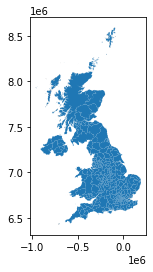

In [3]:
uk_lad = gpd.read_file(
    os.path.join("data", 
                 "Local_Authority_Districts_(December_2019)_Boundaries_UK_BFC",
                 "Local_Authority_Districts__December_2019__Boundaries_UK_BFC.shp")
).set_index("lad19nm", drop=True)
uk_lad.plot()

## Similarity data

Prepared by Anthony

In [4]:
raw_df = pd.read_csv(os.path.join("data", "tfl_similarity_data.csv"), index_col=0)
raw_df

,LAD19NM,adj_dist_base,cor_base_p,adj_dist_yoy,cor_yoy_p,freq
1,Barking and Dagenham,0.550325,0.894644,42.871105,-0.041725,daily
2,Barnet,0.527713,0.931793,29.373171,-0.021281,daily
3,Bexley,0.573596,0.852331,21.578497,-0.016216,daily
4,Brent,0.522242,0.915276,39.095877,-0.030050,daily
5,Bromley,0.527697,0.928521,13.291368,0.014315,daily
...,...,...,...,...,...,...
95,Sutton,3.295924,0.826252,3.299182,0.819372,monthly
96,Tower Hamlets,2.714963,0.953855,2.503504,0.953326,monthly
97,Waltham Forest,3.047321,0.842035,2.986107,0.817104,monthly
98,Wandsworth,2.680965,0.946903,2.488397,0.939548,monthly


Pivot the data so that we have columns for daily, weekly, monthly frequency. _Surely there's a function to do this automatically but probably quicker to do manually:_

In [5]:
df = None  # new, pivotted df
COLS = ["adj_dist_base", "cor_base_p", "adj_dist_yoy", "cor_yoy_p"]
FREQUENCY = ["daily", "weekly", "monthly"]

for i, freq in enumerate(FREQUENCY):
    if i==0:  # First time round need to create the dataframe (using daily frequency as it happens)
        df = raw_df.loc[raw_df.freq==freq].drop(["freq"], axis=1)
    else:  # Otherwise join the other frequency columns to it (weekly, monthly)
        df = df.join(raw_df.drop(['LAD19NM', 'freq'], axis=1), how="left")
    # Rename each of the newly-joinedc olumns, prepending the current frequency
    df = df.rename(columns={ col: f"{freq}_{col}" for col in COLS})
        
df = df.set_index("LAD19NM", drop=True)
df

,daily_adj_dist_base,daily_cor_base_p,daily_adj_dist_yoy,daily_cor_yoy_p,weekly_adj_dist_base,weekly_cor_base_p,weekly_adj_dist_yoy,weekly_cor_yoy_p,monthly_adj_dist_base,monthly_cor_base_p,monthly_adj_dist_yoy,monthly_cor_yoy_p
LAD19NM,,,,,,,,,,,,
Barking and Dagenham,0.550325,0.894644,42.871105,-0.041725,0.550325,0.894644,42.871105,-0.041725,0.550325,0.894644,42.871105,-0.041725
Barnet,0.527713,0.931793,29.373171,-0.021281,0.527713,0.931793,29.373171,-0.021281,0.527713,0.931793,29.373171,-0.021281
Bexley,0.573596,0.852331,21.578497,-0.016216,0.573596,0.852331,21.578497,-0.016216,0.573596,0.852331,21.578497,-0.016216
Brent,0.522242,0.915276,39.095877,-0.030050,0.522242,0.915276,39.095877,-0.030050,0.522242,0.915276,39.095877,-0.030050
Bromley,0.527697,0.928521,13.291368,0.014315,0.527697,0.928521,13.291368,0.014315,0.527697,0.928521,13.291368,0.014315
Camden,0.322300,0.970050,32.365637,-0.014496,0.322300,0.970050,32.365637,-0.014496,0.322300,0.970050,32.365637,-0.014496
City of London,0.199997,0.989993,17.168578,0.012871,0.199997,0.989993,17.168578,0.012871,0.199997,0.989993,17.168578,0.012871
Croydon,0.408478,0.912011,28.729586,-0.018237,0.408478,0.912011,28.729586,-0.018237,0.408478,0.912011,28.729586,-0.018237
Ealing,0.392778,0.946123,21.018646,-0.005625,0.392778,0.946123,21.018646,-0.005625,0.392778,0.946123,21.018646,-0.005625


### Spatialise the similarity data

Join the similarity data to the boundaries

<AxesSubplot:>

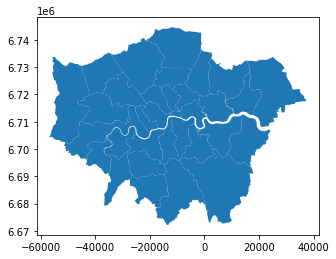

In [6]:
# Don't need to specify columns as both indexes are the LAD name
gdf = uk_lad.join(df, how="right")
# Numeric index is more useful now
gdf = gdf.reset_index()
gdf.plot()

Check that one of the measures looks sensible

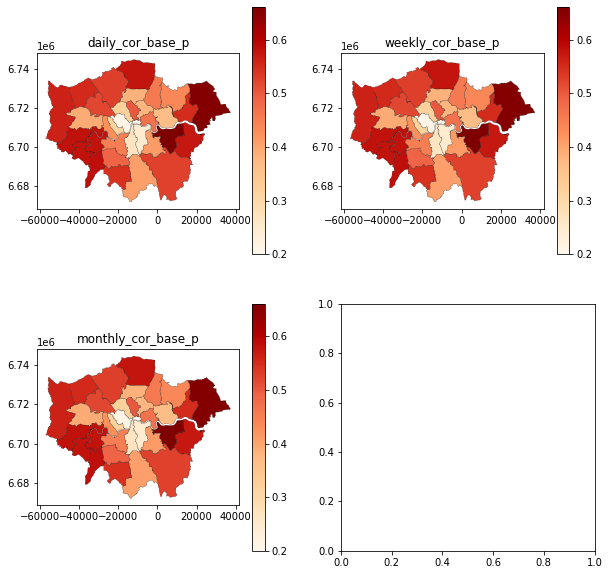

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for (freq, ax) in zip(FREQUENCY, axes.flatten()):
    gdf.plot(ax=ax, column=f"{freq}_adj_dist_base", cmap='OrRd', edgecolor='k', 
             alpha=1.0, linewidth=0.2, legend=True)
    ax.set_title(f"{freq}_cor_base_p")  

## Local Indicators of Spatial Autocorrelation.

Getis-Ord Local G (G*). See [pysal docs](https://pysal.org/esda/generated/esda.G_Local.html#esda.G_Local). 

References for the method:
 - Arthur Getis and J. K. Ord. The analysis of spatial association by use of distance statistics. Geographical Analysis, 24(3):189–206, Sep 2010. URL: http://dx.doi.org/10.1111/j.1538-4632.1992.tb00261.x
 - J. K. Ord and Arthur Getis. Local spatial autocorrelation statistics: distributional issues and an application. Geographical Analysis, 27(4):286–306, Sep 2010. URL: http://dx.doi.org/10.1111/j.1538-4632.1995.tb00912.x

/Users/nick/opt/anaconda3/envs/py39/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))


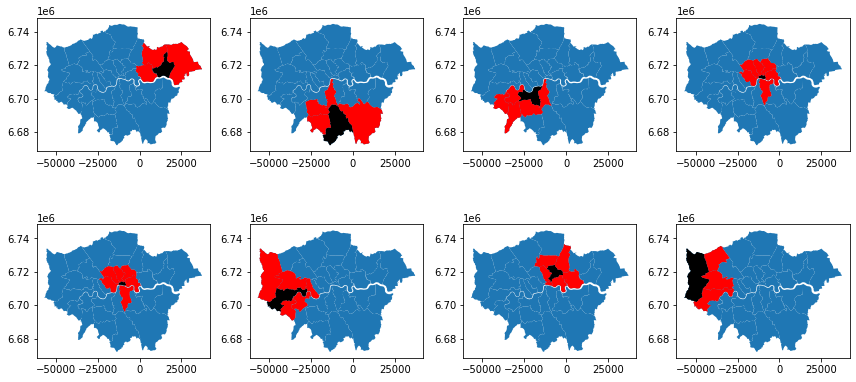

In [8]:
# Create spatial weights from points
THRESHOLD = 20000  # (This is a bit of trial and error. Too small and it creates islands)
#w = libpysal.weights.DistanceBand.from_dataframe(gdf, threshold=THRESHOLD)
w = libpysal.weights.Queen.from_dataframe(gdf)
#w = libpysal.weights.Rook.from_dataframe(energy_intensity)
#w = libpysal.weights.KNN.from_dataframe(gdf, k=10)
#w = libpysal.weights.Kernel.from_dataframe(gdf, fixed = False, function = 'gaussian' )
w.transform = "B"  # Using binary weights

# Check the weights (choose N areas at random and plot it's connected areas
AREA_IDS = [random.randint(0, len(gdf)-1) for _ in range(8)]
fig, axes = plt.subplots(2, 4, figsize=(12,6))
for (area_id, ax) in zip(AREA_IDS, axes.reshape(-1)):
    neighbours = w.full()[0][area_id]
    gdf.plot(ax=ax)
    gdf.loc[[gdf.index[area_id]]].plot(ax=ax, color='black')
    gdf.loc[gdf.index[neighbours.astype(bool)]].plot(ax=ax, color='red')
fig.tight_layout()

Sanity check. Plot the number of neighbours to check that there isn't too much bias to central, highly-connected boroughs

Text(0.5, 1.0, 'Number of neighbours')

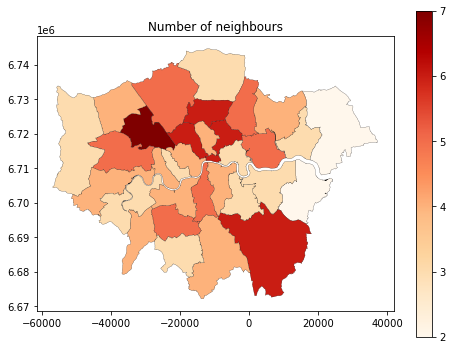

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
temp = gdf.copy()
temp['num_neighbours'] = sum(w.full()[0])  # Index 0 has weights matrix, 1 has list of area names
temp.plot(ax=ax, column='num_neighbours', cmap='OrRd', edgecolor='k', alpha=1.0, linewidth=0.2, legend=True)
ax.set_title("Number of neighbours")
#del temp
# XXXX HERE Oh no, results are just reproducing the neighbours!

Now calculate GI* in a big loop.

Note: once `G_Local` has been called we can access the following information (see [pysal docs](https://splot.readthedocs.io/en/stable/users/tutorials/autocorrelation.html#local-autocorrelation)):
 - `g.Gs`: the G* values (an array)
 - `g.p_sim`: simulated p values
 - `lg.p_sim[lg.p_sim<0.05]`: significant G value

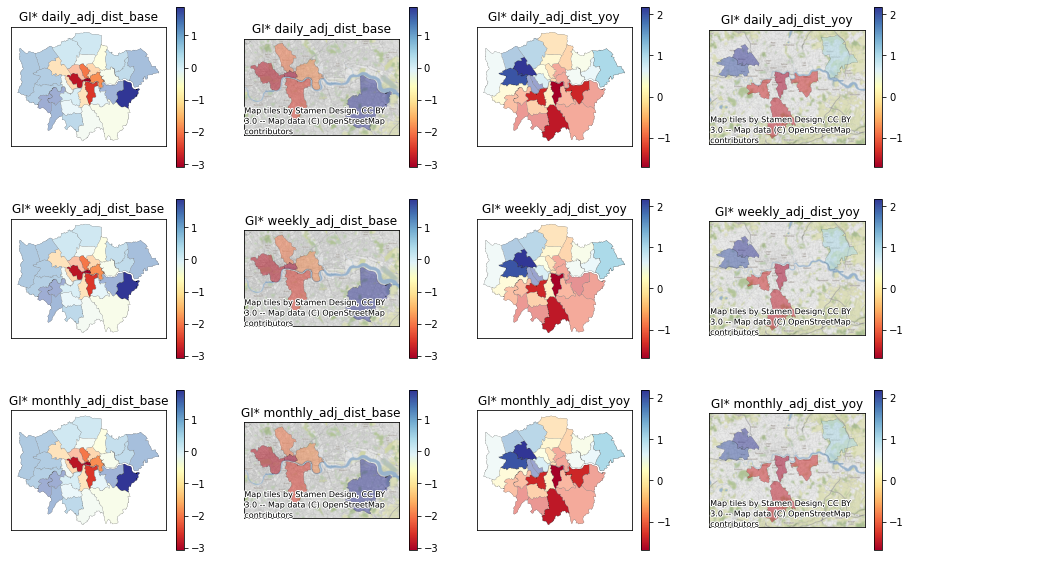

In [21]:
# Big loop to calculate GI* for two variables and three frequencies and map them
vars_to_map = ["adj_dist_base", "adj_dist_yoy"]
fig, axes = plt.subplots(3, 4, figsize=(16,10))  # 3 frequencies by 2 variables and two maps of each

# To keep track of the current axis to plot on
ax_flat = axes.flatten()
ax_count = 0 
        
for freq in FREQUENCY:
    for var in vars_to_map:
        temp = gdf.copy()
        # Variable of interest
        column_name = f"{freq}_{var}"
        y = gdf[column_name].values
        # Applying Getis and Ord local G test using a binary weights object
        g = G_Local(y, w, transform='B', star=True)
        # Attach information back to the datafram
        temp['Gs'] = g.Gs
        temp['Zs'] = g.Zs
        temp['Gs_psig'] = g.p_sim
        temp['Gs_sig'] = g.p_sim<0.05
        
        # Plot the (Z score) of the GI* values, masking out insignificant ones.
        ax1 = ax_flat[ax_count]
        ax2 = ax_flat[ax_count+1]
        ax_count += 2

        # What to map, and colours
        # col = 'Gs' # G values
        col = 'Zs' # Z values
        colour_map = "RdYlBu"
        #colour_map = "OrRd"

        # Plot without basemap
        ax1.set_title(f"GI* {column_name}")
        temp.plot(column=col, cmap=colour_map, edgecolor='k', alpha=1.0, 
                              linewidth=0.2, legend=True, ax=ax1)
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)

        # Mask out non significant
        temp.loc[~temp.Gs_sig]\
                .plot(alpha=0.5, color="white", edgecolor='k', linewidth=0.0, ax=ax1)

        # Plot with basemap (ignoring non significant)
        ax2.set_title(f"GI* {column_name}")
        temp[temp.Gs_sig]\
            .plot(column=col, cmap=colour_map, edgecolor='k', alpha=0.5, linewidth=0.2, legend=True, ax=ax2)
        cx.add_basemap(ax2, crs=gdf.crs)
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
